# Quick tests outside of Test macro

In [1]:
using TestEnv
TestEnv.activate()

"/tmp/jl_3J0wFh/Project.toml"

In [3]:
using GalacticDynamics
using Test
using PythonCall
using CairoMakie
using BenchmarkTools
using Profile, ProfileSVG


pyimport("sys")."path".append("")
pyimport("sys")."path".append("../python")
accelerations_py = pyimport("accelerations")
au = pyimport("astropy.units")
gd = pyimport("gala.dynamics")
gp = pyimport("gala.potential")
gu = pyimport("gala.units")
gi = pyimport("gala.integrate")

Python: <module 'gala.integrate' from '/home/mmestre/.conda/envs/cosmos/lib/python3.11/site-packages/gala/integrate/__init__.py'>

#### Setting up initial conditions and potentials in both Gala and GalacticDynamics

In [4]:
Œît = 0.01
n_step = 1000
t‚ÇÅ = 0.0
t‚ÇÇ = t‚ÇÅ + n_step*Œît
@show t‚ÇÇ
t_range = (t‚ÇÅ, t‚ÇÇ)
x‚ÇÄ = -50.0*SA[1,0,0]
v‚ÇÄ = 200.0*SA[0,1,0]
# x‚ÇÄ = 30*[1,0,1]
# v‚ÇÄ = 100*[0,1,0]
m = 10.0^12*ùï¶.m  # Msun
a = 20.0*ùï¶.l
pot = NFW(m, a)
c = concentration(pot)
f(x) = log(1+x)-x/(1+x)
m_g = m/f(c)
usys = gu.UnitSystem(au.kpc, au.Gyr, au.Msun, au.radian, au.kpc/au.Gyr, au.kpc/au.Gyr^2)
pot_Gala = gp.NFWPotential(Py(adimensional(m_g))*au.Msun, Py(adimensional(a))*au.kpc, units=usys)
w‚ÇÄ = gd.PhaseSpacePosition(pos=Py(x‚ÇÄ)*au.kpc, vel=Py(v‚ÇÄ)*au.kpc/au.Gyr)

t‚ÇÇ = 10.0


Python: <PhaseSpacePosition cartesian, dim=3, shape=()>

### Orbit plot with Gala and GalacticDynamics


ùï§.ode = Vern9(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true,)
sol_gala.t[-1] = <py Quantity 10. Gyr>
sol.t[end] = 10.0
findmax(sol_diff) = (0.00039413660635911896, 978)


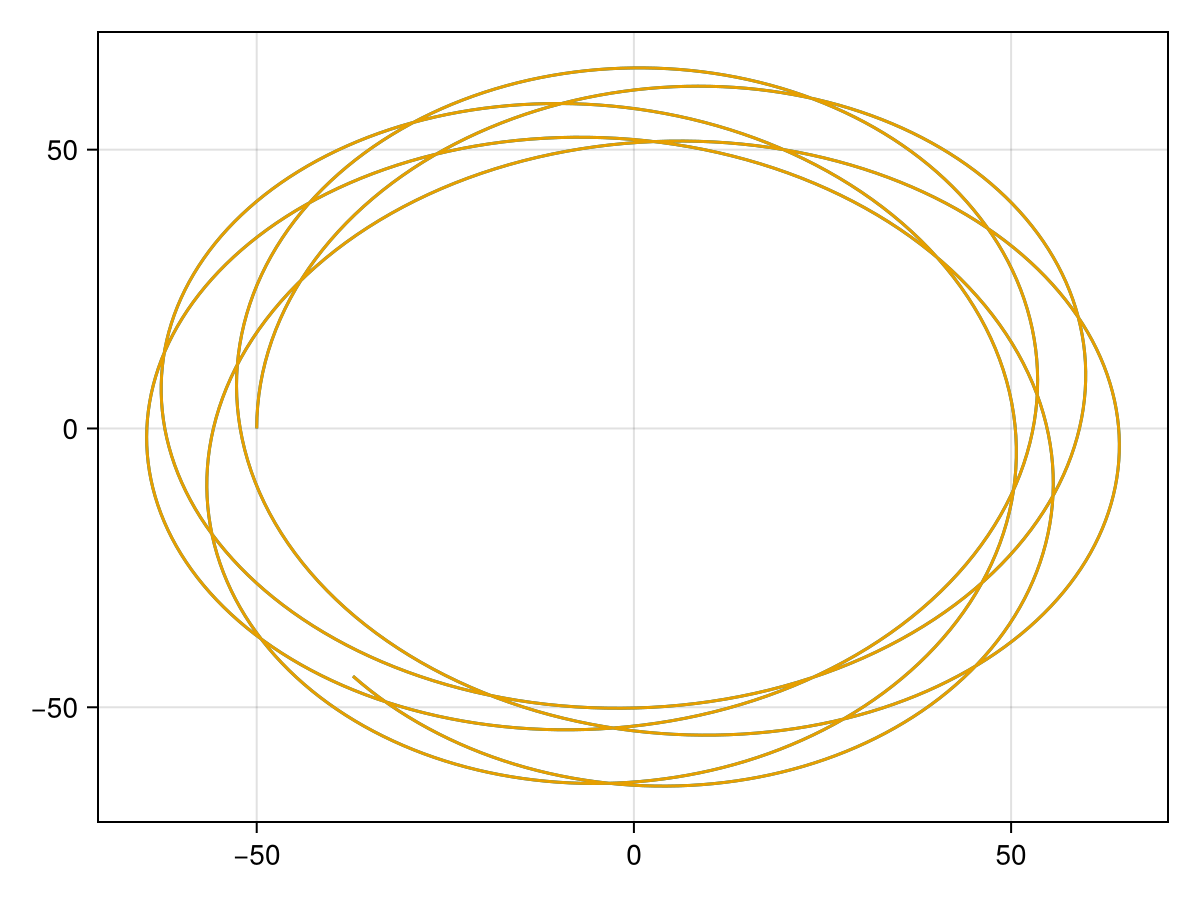

In [5]:
sol_gala = pot_Gala.integrate_orbit(w‚ÇÄ, dt=Œît*au.Gyr, t1=t‚ÇÅ, t2=(t‚ÇÇ+1.e-7)*au.Gyr,
                                    Integrator=gi.DOPRI853Integrator,cython_if_possible=true,
                                    Integrator_kwargs=Py(Dict("rtol"=>5.0e-8)))
sol = evolve(pot, x‚ÇÄ, v‚ÇÄ, t_range, DP8(); options=ntSolverOptions(;reltol=5.0e-8, saveat=Œît))

@show ùï§.ode
@show sol_gala.t[-1]
@show sol.t[end]
orb_gala_x = pyconvert(Vector{Float64}, sol_gala.x)
orb_gala_y = pyconvert(Vector{Float64}, sol_gala.y)
orb_x = sol.x[1,:]
orb_y = sol.x[2,:]
sol_diff = abs.(orb_gala_x-orb_x)
@show findmax(sol_diff)
lines(orb_gala_x,orb_gala_y)
lines!(orb_x,orb_y)
current_figure()



### Precision

#### Precision test between Gala and GalacticDynamics
##### For the NFW
Adding `atol=0.5e-16` in both Gala and GalacticDynamics improves the precision by two orders of magnitude, only when `rtol` is already very small (`< 10^{-16}`).

In [6]:
orb‚ÇÅ = pot_Gala.integrate_orbit(w‚ÇÄ, dt=Œît*au.Gyr, t1=t‚ÇÅ, t2=t‚ÇÇ*au.Gyr,
                                Integrator=gi.DOPRI853Integrator,
                                Integrator_kwargs=Py(Dict("rtol"=>5.0e-8)))
orb‚ÇÇ = pot_Gala.integrate_orbit(w‚ÇÄ, dt=Œît*au.Gyr, t1=t‚ÇÅ, t2=(t‚ÇÇ)*au.Gyr,
                                Integrator=gi.DOPRI853Integrator,
                                Integrator_kwargs=Py(Dict("rtol"=>5.0e-11)))
orb‚ÇÉ = pot_Gala.integrate_orbit(w‚ÇÄ, dt=Œît*au.Gyr, t1=t‚ÇÅ, t2=(t‚ÇÇ)*au.Gyr,
                                Integrator=gi.DOPRI853Integrator,
                                Integrator_kwargs=Py(Dict("rtol"=>5.0e-20, "atol"=>0.5e-20)))
orb‚ÇÑ = evolve(pot, x‚ÇÄ, v‚ÇÄ, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-8, saveat=Œît))
orb‚ÇÖ = evolve(pot, x‚ÇÄ, v‚ÇÄ, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-11,saveat=Œît))
orb‚ÇÜ = evolve(pot, x‚ÇÄ, v‚ÇÄ, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-16, abstol=0.5e-16, saveat=Œît))
orb‚Çá = evolve(pot, x‚ÇÄ, v‚ÇÄ, t_range, Vern9(); options=ntSolverOptions(;reltol=5.0e-6, saveat=Œît))
orb‚Çà = evolve(pot, x‚ÇÄ, v‚ÇÄ, t_range, Vern9(); options=ntSolverOptions(;reltol=5.0e-11,saveat=Œît))
orb‚Çâ = evolve(pot, x‚ÇÄ, v‚ÇÄ, t_range, Vern9(); options=ntSolverOptions(;reltol=5.0e-16, abstol=0.5e-16,
saveat=Œît))
@show orb‚ÇÅ.x[-1]  orb‚ÇÇ.x[-1]  orb‚ÇÉ.x[-1]
@show orb‚ÇÑ.x[1,end]  orb‚ÇÖ.x[1,end]  orb‚ÇÜ.x[1,end]
@show orb‚Çá.x[1,end]  orb‚Çà.x[1,end]  orb‚Çâ.x[1,end]
@show orb‚ÇÑ.x[1,end]-orb‚ÇÅ.x[-1].value  orb‚ÇÖ.x[1,end]-orb‚ÇÇ.x[-1].value  orb‚ÇÜ.x[1,end]-orb‚ÇÉ.x[-1].value
@show orb‚Çá.x[1,end]-orb‚ÇÅ.x[-1].value  orb‚Çà.x[1,end]-orb‚ÇÇ.x[-1].value  orb‚Çâ.x[1,end]-orb‚ÇÉ.x[-1].value
@show orb‚Çá.x[1,end]-orb‚ÇÑ.x[1,end]  orb‚Çà.x[1,end]-orb‚ÇÖ.x[1,end]  orb‚Çâ.x[1,end]-orb‚ÇÜ.x[1,end]
@test orb‚ÇÑ.x[1,end] ‚âà pyconvert(Float64,orb‚ÇÅ.x[-1].value)  rtol=5.0e-8
@test orb‚ÇÖ.x[1,end] ‚âà pyconvert(Float64,orb‚ÇÇ.x[-1].value)  rtol=5.0e-10
@test orb‚ÇÜ.x[1,end] ‚âà pyconvert(Float64,orb‚ÇÉ.x[-1].value)  rtol=5.0e-12


orb‚ÇÅ.x[-1] = <py Quantity -37.23718442 kpc>
orb‚ÇÇ.x[-1] = <py Quantity -37.23718442 kpc>
orb‚ÇÉ.x[-1] = <py Quantity -37.23718442 kpc>
orb‚ÇÑ.x[1, end] = -37.237185772998345
orb‚ÇÖ.x[1, end] = -37.237184420460025
orb‚ÇÜ.x[1, end] = -37.2371844195847
orb‚Çá.x[1, end] = -37.23739034144379
orb‚Çà.x[1, end] = -37.237184420997416
orb‚Çâ.x[1, end] = -37.237184419581304
orb‚ÇÑ.x[1, end] - (orb‚ÇÅ.x[-1]).value = <py -1.353432267592325e-06>
orb‚ÇÖ.x[1, end] - (orb‚ÇÇ.x[-1]).value = <py -8.939480267144972e-10>
orb‚ÇÜ.x[1, end] - (orb‚ÇÉ.x[-1]).value = <py -1.709565822238801e-11>
orb‚Çá.x[1, end] - (orb‚ÇÅ.x[-1]).value = <py -0.00020592187771484305>
orb‚Çà.x[1, end] - (orb‚ÇÇ.x[-1]).value = <py -1.4313386031972186e-09>
orb‚Çâ.x[1, end] - (orb‚ÇÉ.x[-1]).value = <py -1.3699263945454732e-11>
orb‚Çá.x[1, end] - orb‚ÇÑ.x[1, end] = -0.00020456844544725072
orb‚Çà.x[1, end] - orb‚ÇÖ.x[1, end] = -5.373905764827214e-10
orb‚Çâ.x[1, end] - orb‚ÇÜ.x[1, end] = 3.396394276933279e-12


Test Passed

#### Precision test between Gala and GalacticDynamics
##### For the MN disk

In [6]:
gp = pyimport("gala.potential")
gd= pyimport("gala.dynamics")
gu = pyimport("gala.units")
pot_mn = gp.MiyamotoNagaiPotential(m=2.5E11*au.Msun, a=6.5*au.kpc,b=0.26*au.kpc, units=gu.galactic)
w0 = gd.PhaseSpacePosition(pos=Py([11., 0., 0.2])*au.kpc, vel=Py([0., 200, 100])*au.km/au.s)
orb‚ÇÅ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator)
orb‚ÇÇ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator, Integrator_kwargs=Py(Dict("rtol"=>5.0e-15)))
orb‚ÇÉ_c = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator,  cython_if_possible=true, Integrator_kwargs=Py(Dict("rtol"=>5.0e-5)))
orb‚ÇÉ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator, Integrator_kwargs=Py(Dict("rtol"=>5.0e-5)))
orb‚ÇÑ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.LeapfrogIntegrator)
orb‚ÇÖ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.LeapfrogIntegrator, Integrator_kwargs=Py(Dict("rtol"=>5.0e-15)))
@show orb‚ÇÅ.x[-1] orb‚ÇÇ.x[-1] orb‚ÇÉ_c.x[-1] orb‚ÇÉ.x[-1]  orb‚ÇÑ.x[-1] orb‚ÇÖ.x[-1];

orb‚ÇÅ.x[-1] = <py Quantity 6.76980261 kpc>
orb‚ÇÇ.x[-1] = <py Quantity 6.76980261 kpc>
orb‚ÇÉ_c.x[-1] = <py Quantity 6.76980252 kpc>
orb‚ÇÉ.x[-1] = <py Quantity 6.76980252 kpc>
orb‚ÇÑ.x[-1] = <py Quantity 6.74183738 kpc>
orb‚ÇÖ.x[-1] = <py Quantity 6.74183738 kpc>


#### This is another NFW orbit test that originally couldn't be integrated in Julia due to abrupt reduction of step size.
#### Problem solved: I was taking an initial condition that with radial orbit!

In [28]:
usys = gu.UnitSystem(au.kpc, au.Gyr, au.Msun, au.radian, au.kpc/au.Gyr, au.kpc/au.Gyr^2)
Œît = 0.01
n_step = 1000
t‚ÇÅ = 0.0
t‚ÇÇ = t‚ÇÅ + n_step*Œît
@show t‚ÇÇ
t_range = (t‚ÇÅ, t‚ÇÇ)

x‚ÇÄ = 30*[1,0,1]
v‚ÇÄ = 200*[0,1,0]
m = 10^12*ùï¶.m  # Msun
a = 20*ùï¶.l
pot = NFW(m, a)
c = concentration(pot)
f(x) = log(1+x)-x/(1+x)
m_g = m/f(c)
pot_Gala = gp.NFWPotential(Py(adimensional(m_g))*au.Msun, Py(adimensional(a))*au.kpc, units=usys)
@show pot_Gala

# Gala.py solution
w‚ÇÄ = gd.PhaseSpacePosition(pos=Py(x‚ÇÄ)*au.kpc, vel=Py(v‚ÇÄ)*au.kpc/au.Gyr)
orb_gala = pot_Gala.integrate_orbit(w‚ÇÄ, dt=Œît*au.Gyr, t1=t‚ÇÅ, t2=(t‚ÇÇ)*au.Gyr,
Integrator=gi.DOPRI853Integrator,Integrator_kwargs=Py(Dict("rtol"=>5.0e-14, "atol"=>0.5e-14)))
orb_gala_t = pyconvert(Vector{Float64}, orb_gala.t)
orb_gala_x = pyconvert(Vector{Float64}, orb_gala.x)
orb_gala_y = pyconvert(Vector{Float64}, orb_gala.y)
orb_gala_z = pyconvert(Vector{Float64}, orb_gala.z)
# GalacticDynamics.jl solution
sol = evolve(pot, x‚ÇÄ, v‚ÇÄ, t_range, Vern9(); options=ntSolverOptions(; reltol=5.0e-14, abstol=0.5e-14, saveat=Œît))
@show sol.t
orb_t = ustrip.(physical_units.(sol.t,:t))
orb_x = sol.x[1,:]

@test orb_t[end] ‚âà orb_gala_t[end] rtol=5.0e-12
@test orb_x[end] ‚âà orb_gala_x[end] rtol=5.0e-12

t‚ÇÇ = 10.0
pot_Gala = <py NFWPotential: m=6.52e+11, r_s=20.00, a=1.00, b=1.00, c=1.00 (kpc,Gyr,solMass,rad)>
sol.t = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.

Test Passed

### Speed tests

#### BenchmarkTools only tests memory consumption on the Julia side. The time is real as long as C is not working asynchronously.

In [181]:
@benchmark pot_Gala.integrate_orbit(w‚ÇÄ, dt=Œît*au.Gyr, t1=t‚ÇÅ, t2=(t‚ÇÇ)*au.Gyr,
                                    Integrator=gi.DOPRI853Integrator,
                                    Integrator_kwargs=Py(Dict("rtol"=>5.0e-16, "atol"=>0.5e-16)))

BenchmarkTools.Trial: 261 samples with 1 evaluation.
 Range (min ‚Ä¶ max):  18.234 ms ‚Ä¶ 27.463 ms  ‚îä GC (min ‚Ä¶ max): 0.00% ‚Ä¶ 0.00%
 Time  (median):     18.869 ms              ‚îä GC (median):    0.00%
 Time  (mean ¬± œÉ):   19.180 ms ¬±  1.125 ms  ‚îä GC (mean ¬± œÉ):  0.00% ¬± 0.00%

     ‚ñÖ‚ñá‚ñà‚ñá‚ñÉ ‚ñÅ‚ñÅ                                                  
  ‚ñÇ‚ñÑ‚ñá‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñÑ‚ñÑ‚ñÑ‚ñÖ‚ñÉ‚ñÉ‚ñÉ‚ñÇ‚ñÉ‚ñÇ‚ñÉ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÉ‚ñÉ‚ñÇ‚ñÇ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÇ‚ñÅ‚ñÇ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÅ‚ñÅ‚ñÉ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ ‚ñÉ
  18.2 ms         Histogram: frequency by time        23.9 ms <

 Memory estimate: 3.02 KiB, allocs estimate: 141.

In [182]:
@benchmark pot_Gala.integrate_orbit(w‚ÇÄ, dt=Œît*au.Gyr, t1=t‚ÇÅ, t2=(t‚ÇÇ)*au.Gyr,
                                    Integrator=gi.DOPRI853Integrator,
                                    cython_if_possible=true,
                                    Integrator_kwargs=Py(Dict("rtol"=>5.0e-16, "atol"=>0.5e-16)))


BenchmarkTools.Trial: 262 samples with 1 evaluation.
 Range (min ‚Ä¶ max):  18.252 ms ‚Ä¶ 43.710 ms  ‚îä GC (min ‚Ä¶ max): 0.00% ‚Ä¶ 0.00%
 Time  (median):     18.947 ms              ‚îä GC (median):    0.00%
 Time  (mean ¬± œÉ):   19.063 ms ¬±  1.556 ms  ‚îä GC (mean ¬± œÉ):  0.00% ¬± 0.00%

                  ‚ñÅ ‚ñÇ ‚ñÑ‚ñÅ‚ñÅ‚ñÅ‚ñÜ ‚ñá‚ñÅ‚ñÑ‚ñà‚ñÅ‚ñÅ    ‚ñÅ  ‚ñÅ‚ñÅ                    
  ‚ñÉ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÉ‚ñÖ‚ñÅ‚ñÉ‚ñÉ‚ñÖ‚ñÜ‚ñÅ‚ñÖ‚ñÖ‚ñÖ‚ñà‚ñÖ‚ñà‚ñÖ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñÜ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñÜ‚ñÖ‚ñÖ‚ñÑ‚ñà‚ñÉ‚ñá‚ñà‚ñà‚ñÖ‚ñÑ‚ñÜ‚ñá‚ñÑ‚ñÑ‚ñÉ‚ñÉ‚ñÉ‚ñÉ‚ñÅ‚ñÅ‚ñÉ‚ñÉ‚ñÅ‚ñÅ‚ñÅ‚ñÉ ‚ñÑ
  18.3 ms         Histogram: frequency by time        19.8 ms <

 Memory estimate: 3.26 KiB, allocs estimate: 144.

In [187]:
@benchmark evolve(pot, x‚ÇÄ, v‚ÇÄ, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-16, abstol=0.5e-16, saveat=Œît))

BenchmarkTools.Trial: 339 samples with 1 evaluation.
 Range (min ‚Ä¶ max):  13.523 ms ‚Ä¶ 22.993 ms  ‚îä GC (min ‚Ä¶ max): 0.00% ‚Ä¶ 37.89%
 Time  (median):     14.357 ms              ‚îä GC (median):    0.00%
 Time  (mean ¬± œÉ):   14.748 ms ¬±  1.210 ms  ‚îä GC (mean ¬± œÉ):  0.51% ¬±  2.81%

      ‚ñÑ‚ñÜ‚ñà‚ñÅ                                                     
  ‚ñÉ‚ñÑ‚ñÑ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñÖ‚ñá‚ñá‚ñÖ‚ñÜ‚ñÜ‚ñÑ‚ñÑ‚ñÑ‚ñÉ‚ñÉ‚ñÇ‚ñÉ‚ñÉ‚ñÇ‚ñÇ‚ñÉ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÉ‚ñÇ‚ñÅ‚ñÇ‚ñÅ‚ñÅ‚ñÇ‚ñÅ‚ñÅ‚ñÇ‚ñÅ‚ñÅ‚ñÇ‚ñÇ‚ñÅ‚ñÅ‚ñÇ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÉ ‚ñÉ
  13.5 ms         Histogram: frequency by time        20.4 ms <

 Memory estimate: 2.77 MiB, allocs estimate: 148.

In [195]:
@benchmark evolve(pot, x‚ÇÄ, v‚ÇÄ, (t‚ÇÅ,t‚ÇÇ/10), DP8(); options=ntSolverOptions(;reltol=5.0e-16, saveat=Œît))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min ‚Ä¶ max):  339.540 Œºs ‚Ä¶   7.443 ms  ‚îä GC (min ‚Ä¶ max): 0.00% ‚Ä¶ 87.05%
 Time  (median):     368.606 Œºs               ‚îä GC (median):    0.00%
 Time  (mean ¬± œÉ):   397.793 Œºs ¬± 197.694 Œºs  ‚îä GC (mean ¬± œÉ):  3.10% ¬±  6.06%

    ‚ñà‚ñá‚ñÑ                                                          
  ‚ñÉ‚ñÖ‚ñà‚ñà‚ñà‚ñá‚ñÜ‚ñÜ‚ñÖ‚ñÑ‚ñÖ‚ñÖ‚ñÖ‚ñÉ‚ñÉ‚ñÉ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ ‚ñÇ
  340 Œºs           Histogram: frequency by time          646 Œºs <

 Memory estimate: 283.80 KiB, allocs estimate: 144.

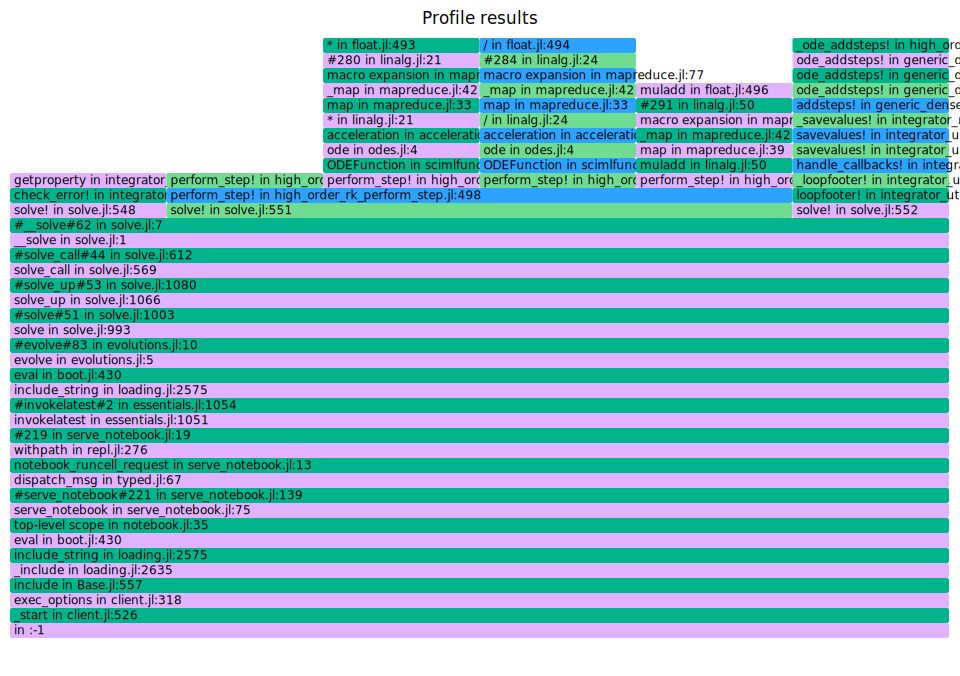

In [19]:
ProfileSVG.@profview evolve(pot, x‚ÇÄ, v‚ÇÄ, t_range, DP8(); options=ntSolverOptions(; reltol=5.0e-16, abstol=0.5e-16, saveat=Œît))

#### Benchmark difference between using or not @unpack macro inside functions.

In [32]:
function potential_packed(pot::MiyamotoNagaiDisk, x::AbstractArray{T}) where {T<:Real}
    return -G*pot.m/sqrt( x[1:2]'x[1:2] + (pot.a + sqrt(pot.b^2+x[3]^2))^2 )
end
pot = MiyamotoNagaiDisk(10.0^11, 30., 5.)
x = [10,0, 5]

3-element Vector{Int64}:
 10
  0
  5

In [36]:
@benchmark potential(pot, x)

BenchmarkTools.Trial: 10000 samples with 983 evaluations.
 Range (min ‚Ä¶ max):  57.964 ns ‚Ä¶  25.624 Œºs  ‚îä GC (min ‚Ä¶ max):  0.00% ‚Ä¶ 99.40%
 Time  (median):     63.711 ns               ‚îä GC (median):     0.00%
 Time  (mean ¬± œÉ):   87.841 ns ¬± 384.624 ns  ‚îä GC (mean ¬± œÉ):  14.37% ¬±  3.69%

  ‚ñÖ‚ñà‚ñÜ‚ñÜ‚ñÑ‚ñÉ‚ñÉ‚ñÇ‚ñÅ  ‚ñÇ‚ñÅ ‚ñÇ‚ñÑ‚ñÉ‚ñÉ‚ñÑ‚ñÉ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ ‚ñÅ                             ‚ñÇ
  ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñá‚ñá‚ñá‚ñá‚ñá‚ñá‚ñá‚ñá‚ñá‚ñá‚ñá‚ñá‚ñÜ‚ñÜ‚ñÖ‚ñÜ‚ñÜ‚ñÜ‚ñÖ‚ñÜ‚ñÖ‚ñÜ‚ñÜ‚ñÖ‚ñÑ ‚ñà
  58 ns         Histogram: log(frequency) by time       160 ns <

 Memory estimate: 112 bytes, allocs estimate: 3.

In [37]:
@benchmark potential_packed(pot, x)

BenchmarkTools.Trial: 10000 samples with 983 evaluations.
 Range (min ‚Ä¶ max):  57.931 ns ‚Ä¶  26.444 Œºs  ‚îä GC (min ‚Ä¶ max):  0.00% ‚Ä¶ 99.65%
 Time  (median):     64.760 ns               ‚îä GC (median):     0.00%
 Time  (mean ¬± œÉ):   87.681 ns ¬± 402.650 ns  ‚îä GC (mean ¬± œÉ):  13.32% ¬±  3.28%

  ‚ñÑ‚ñà‚ñÜ‚ñÜ‚ñÖ‚ñÉ‚ñÉ‚ñÉ‚ñÅ‚ñÅ ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÑ‚ñÑ‚ñÑ‚ñÑ‚ñÑ‚ñÉ‚ñÉ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÅ‚ñÅ‚ñÅ                               ‚ñÇ
  ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñá‚ñá‚ñá‚ñà‚ñÜ‚ñá‚ñá‚ñÜ‚ñá‚ñá‚ñÜ‚ñÜ‚ñÜ‚ñá‚ñá‚ñÜ‚ñÜ‚ñÖ‚ñÜ‚ñÖ‚ñÖ‚ñÜ‚ñÜ‚ñÜ ‚ñà
  57.9 ns       Histogram: log(frequency) by time       153 ns <

 Memory estimate: 112 bytes, allocs estimate: 3.